In [30]:
#%matplotlib inline 
%matplotlib inline
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')


In [14]:
direc = "/home/angps/Documents/WorldCupPrediction/dataset/"
cleaned_direc = "/home/angps/Documents/WorldCupPrediction/cleaned dataset/"
countries = pd.read_csv(direc + "01 2018 World Cup Team Statistics.csv")
historical = pd.read_csv(direc + "02 Historical Data on World Cup Matches.csv")
player_stats_18 = pd.read_csv(direc + "03 2018 FIFA Players Database.csv")
wc_fixtures = pd.read_csv(direc + "05 2018 World Cup Match Fixtures.csv")
matches = pd.read_csv(cleaned_direc + "cleaned_matches.csv")
squads = pd.read_csv(direc + "2018 FIFA World Cup Squads.csv")
fifa18 = pd.read_csv(direc + "complete.csv")

In [15]:
wc_countries = countries[countries.team.isin(squads.Team)]
wc_countries.head()

,team,team_code,group,Soccer_power_index,Offence_rating,Defence_rating,Average_age,Average_height,june_fifa_rank,june_fifa_points,all_time_fifa_ranking,total_world_cup_points,total_world_cup_matches_played,total_worldcup_match_wins,total_worldcup_match_draws,total_worldcup_match_losses,total_worldcup_match_goals_scored,total_worldcup_match_goals_against,total_worldcup_match_average_points,total_worldcup_appearances
0,Argentina,ARG,D,87.14876,2.57571,0.40808,28.4,179.4,5,1241,4.0,140.0,77.0,42.0,14.0,21.0,131.0,84.0,1.8,16.0
1,Australia,AUS,C,62.52712,1.80032,1.01758,26.9,181.3,36,718,46.0,9.0,13.0,2.0,3.0,8.0,11.0,26.0,0.7,4.0
2,Belgium,BEL,G,85.40682,2.81096,0.63262,27.0,183.8,3,1298,14.0,51.0,41.0,14.0,9.0,18.0,52.0,66.0,1.1,12.0
3,Brazil,BRA,E,92.39264,3.05704,0.31349,27.8,180.4,2,1431,1.0,227.0,104.0,70.0,17.0,17.0,221.0,102.0,2.2,20.0
4,Colombia,COL,H,80.52894,2.18240,0.51246,27.3,180.2,16,986,28.0,23.0,18.0,7.0,2.0,9.0,26.0,27.0,1.3,5.0


In [16]:
squads.Player = squads.Player.apply(lambda x: x[:-10] if "captain" in x else x)
squads.head()

,Team,Group,Squad Number,Position,Player,Date Of Birth,Age,Caps,Goals,Club,Player Count
0,Egypt,A,1,GK,Essam El-Hadary,1973/01/15,45,157,0,Al-Taawoun,1
1,Egypt,A,2,DF,Ali Gabr,1989/01/01,29,20,1,West Bromwich Albion,1
2,Egypt,A,3,DF,Ahmed Elmohamady,1987/09/09,30,77,2,Aston Villa,1
3,Egypt,A,4,MF,Omar Gaber,1992/01/30,26,23,0,Los Angeles FC,1
4,Egypt,A,5,MF,Sam Morsy,1991/09/10,26,4,0,Wigan Athletic,1


In [17]:
wc_player_stats_18 = fifa18[fifa18["name"].isin(squads.Player) | fifa18["full_name"].isin(squads.Player)]
wc_player_stats_18.shape

(565, 185)

In [18]:
fifa18 = fifa18.replace({"Korea Republic":"South Korea"})

In [19]:
wc_fifa18_stats = fifa18[fifa18.nationality.isin(squads.Team)]
len(wc_fifa18_stats.nationality.unique()),wc_fifa18_stats.shape

(32, (12005, 185))

**Let's get the top 30 players from each WC countries as a representation for the country.**

In [20]:
wc_fifa18_stats.replace([False,"False",True,"True"],[0,0,1,1])
unused_var=[]
for i in fifa18.columns:
    if "prefers" in i:
        unused_var.append(i)
wc_fifa18_stats = wc_fifa18_stats.drop(["club_logo","ID","real_face","birth_date","flag","photo"],axis=1)
wc_fifa18_stats = wc_fifa18_stats.drop(unused_var,axis=1)
grouped_wc_fifa18_stats = wc_fifa18_stats.groupby(['nationality']).apply(lambda x: (x.sort_values('overall',ascending=False)).head(30).mean()).sort_values('potential',ascending=True)
grouped_wc_fifa18_stats

,special,age,height_cm,weight_kg,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,rs,rw,rf,ram,rcm,rm,rdm,rcb,rb,rwb,st,lw,cf,cam,cm,lm,cdm,cb,lb,lwb,ls,lf,lam,lcm,ldm,lcb,gk,1_on_1_rush_trait,acrobatic_clearance_trait,argues_with_officials_trait,avoids_using_weaker_foot_trait,backs_into_player_trait,bicycle_kicks_trait,cautious_with_crosses_trait,chip_shot_trait,chipped_penalty_trait,comes_for_crosses_trait,corner_specialist_trait,diver_trait,dives_into_tackles_trait,diving_header_trait,driven_pass_trait,early_crosser_trait,fan's_favourite_trait,fancy_flicks_trait,finesse_shot_trait,flair_trait,flair_passes_trait,gk_flat_kick_trait,gk_long_throw_trait,gk_up_for_corners_trait,giant_throw_in_trait,inflexible_trait,injury_free_trait,injury_prone_trait,leadership_trait,long_passer_trait,long_shot_taker_trait,long_throw_in_trait,one_club_player_trait,outside_foot_shot_trait,playmaker_trait,power_free_kick_trait,power_header_trait,puncher_trait,rushes_out_of_goal_trait,saves_with_feet_trait,second_wind_trait,selfish_trait,skilled_dribbling_trait,stutter_penalty_trait,swerve_pass_trait,takes_finesse_free_kicks_trait,target_forward_trait,team_player_trait,technical_dribbler_trait,tries_to_beat_defensive_line_trait,poacher_speciality,speedster_speciality,aerial_threat_speciality,dribbler_speciality,playmaker_speciality,engine_speciality,distance_shooter_speciality,crosser_speciality,free_kick_specialist_speciality,tackling_speciality,tactician_speciality,acrobat_speciality,strength_speciality,clinical_finisher_speciality
nationality,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Panama,1617.375000,25.812500,181.750000,76.500000,8.378125e+05,3312.500000,1.344812e+06,65.812500,69.437500,66.062500,51.187500,52.187500,58.250000,50.312500,68.812500,1.000000,2.625000,2.625000,48.562500,46.500000,58.250000,57.375000,44.750000,55.625000,46.312500,42.875000,52.250000,59.937500,65.750000,66.500000,62.687500,62.687500,61.312500,61.687500,64.312500,66.812500,71.875000,52.000000,64.562500,48.937500,50.562500,50.062500,54.125000,58.562500,48.750000,50.375000,48.625000,9.687500,11.687500,12.062500,8.875000,11.000000,56.625000,56.000000,56.250000,55.625000,55.437500,56.437500,55.437500,55.750000,55.375000,55.562500,56.625000,56.000000,56.250000,55.625000,55.437500,56.437500,55.437500,55.750000,55.375000,55.562500,56.625000,56.250000,55.625000,55.437500,55.437500,55.750000,NaN,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.062500,0.0,0.000000,0.000000,0.000000,0.062500,0.0,0.0,0.000000,0.0,0.0,0.000000,0.062500,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.062500,0.062500,0.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.062500,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000
Tunisia,1677.966667,27.266667,182.700000,76.666667,2.261167e+06,11700.000000,2.739000e+06,68.966667,71.533333,66.200000,56.266667,60.300000,64.233333,49.233333,66.333333,1.166667,2.600000,3.066667,55.466667,51.600000,58.300000,64.666667,49.466667,62.000000,51.700000,49.200000,58.000000,63.933333,65.533333,65.700000,65.533333,63.733333,63.366667,61.966667,63.500000,65.166667,68.333333,54.800000,60.266667,48.466667,54.366667,58.166667,52.766667,62.900000,45.033333,48.500000,45.433333,12.233333,12.266667,12.200000,13.166667,13.133333,60.6896

Lets visualise the overall ability and potential of the 32 countries.

In [21]:
grouped_wc_fifa18_stats["Points_to_max_potential"] = grouped_wc_fifa18_stats["potential"] - grouped_wc_fifa18_stats["overall"]

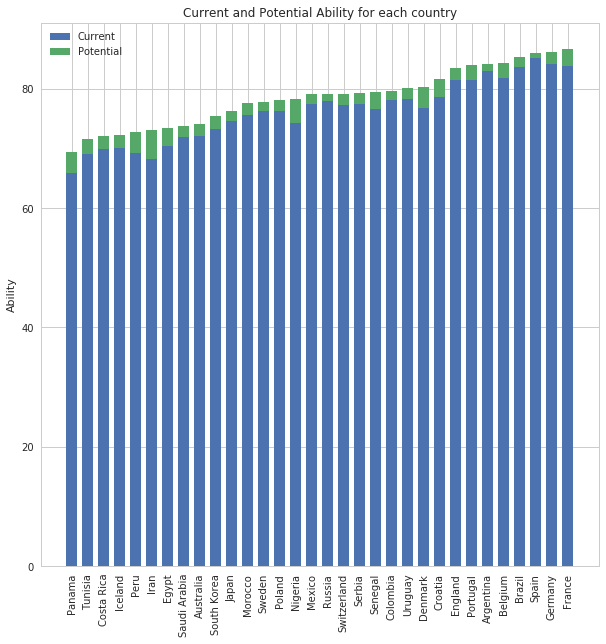

In [46]:
curr = grouped_wc_fifa18_stats["overall"]
pot = grouped_wc_fifa18_stats["Points_to_max_potential"]
ind = np.arange(32)
width = 0.7
plt.figure(figsize=(10,10))
p1 = plt.bar(ind,curr, width)
p2 = plt.bar(ind,pot, width, bottom=curr)

plt.ylabel('Ability')
plt.title('Current and Potential Ability for each country')
plt.xticks(ind,(grouped_wc_fifa18_stats.index),rotation=90)
plt.legend((p1[0], p2[0]), ('Current', 'Potential'))

plt.show()

We can see that France has the highest potential while Spain has the highest current ability.